# Etapes

<br/>

1. Fusionner les jeux de données de test et de train
2. Appliquer des pré-traitements (élimination des stop words, passage en minuscules/majuscules, lemmatisation, racinisation (stemming), tokenisation, vectorisation, NER, POS tagging, ...) et sauvegarder chacun des jeux de données traités pour gagner du temps (comme expliqué par M. Poncelet en TD)
3. Ingénierie des données : choisir une méthode de représentation du texte (par exemple bag of words ou tf-idf) de manière à ce qu'il soit compréhensible et utilisable pour un modèle de classification, sortir des features. Potentiellement : modélisation par sujets (topic modeling), reconnaissance d'entités (entity recognition).
4. Choisir un classifieur adapté. Nous nous intéresserons à trois tâches de classification :

    - {VRAI} vs. {FAUX} (deux classes)
    - {VRAI ou FAUX} vs. {AUTRE} (deux classes)
    - {VRAI} vs. {FAUX} vs. {MIXTE} vs. {AUTRE} (quatre classes)

    Appliquer de l'upsampling ou du downsampling pour équilibrer les données.
    
    Modèles de classification envisagés : arbres de décision, SVMs, Naïve Bayes, les K-NN, les random forests, etc.
5. Sélection de variable (feature selection): pour chacune des trois tâches de classification, en plus des modèles de classification, préparer une liste de features discriminantes en ordre décroissant. Pour cela, s'appuyer sur des méthodes de sélection de variables (ou de features). Tirer les conclusions.
6. Analyse des erreurs, validation et comparaisons des modèles : comparer empiriquement les différents choix quevous avez pu faire dans la partie sélection des features, des prétraitements, des modèles
utilisés, de l'échantillonnage, etc. par rapport à leur impact sur la qualité de la classification.

In [24]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package stopwords to /Users/Louis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Louis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Louis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
dataframe = pd.read_csv("../data/HAI817_Projet_test.csv")

In [26]:
def to_lower_case(text):
    return text.lower()

def to_upper_case(text):
    return text.upper()

def generate_wordcloud(data):
    text = ' '.join(data)
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          stopwords = set(stopwords.words('english')), 
                          min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    
def basic_preprocessing(text):
    # Supprimer les caractères non-alphabétiques et les chiffres
    text = re.sub(r"[^a-zA-Z\s]", "", text, re.I|re.A)
    # Suppression des stopwords
    stop_words = set(stopwords.words("english"))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_tokens]
    return ' '.join(lemma_words)

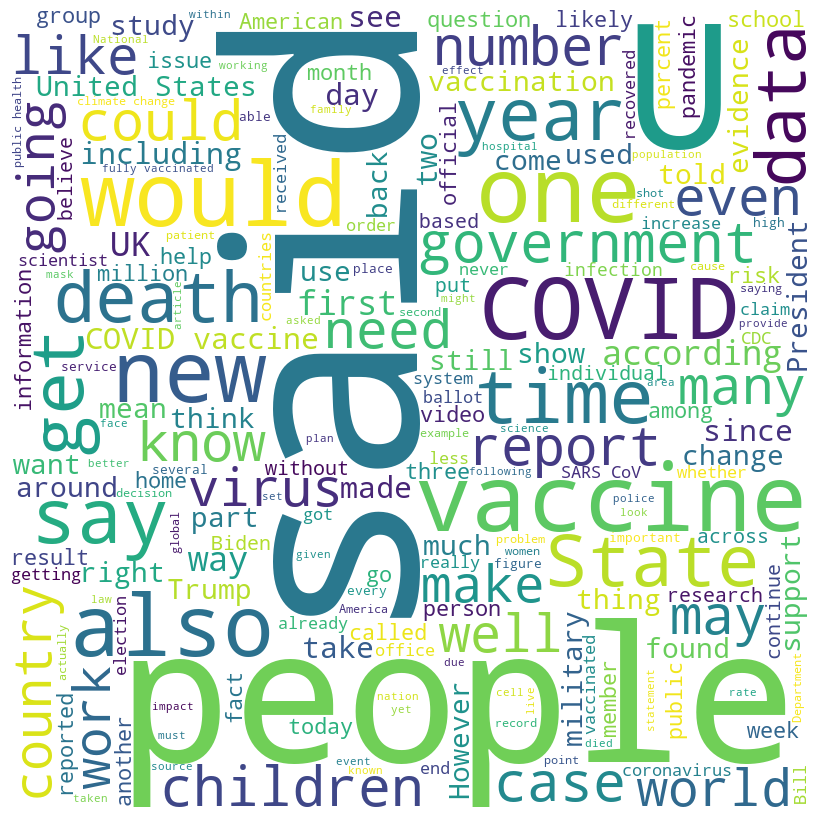

In [27]:
dataframe["text_lower"] = dataframe["text"].apply(to_lower_case)
dataframe["text_lower"].to_csv("text_lower.csv", index=False)

dataframe["text_upper"] = dataframe["text"].apply(to_upper_case)
dataframe["text_upper"].to_csv("text_upper.csv", index=False)

dataframe["text_preprocessed"] = dataframe["text"].apply(basic_preprocessing)
dataframe["text_preprocessed"].to_csv("text_preprocessed.csv", index=False)

generate_wordcloud(dataframe["text"].values)